In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Dense



# Loading the data

In [2]:
df = pd.read_csv(r'C:\Users\vishw\Downloads\ner_dataset (1).csv', encoding='unicode_escape', usecols=['Sentence #','Word','Tag'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99998 entries, 0 to 99997
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Sentence #  4543 non-null   object
 1   Word        99998 non-null  object
 2   Tag         99998 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB


In [4]:
df.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,NaN,of,O
2,NaN,demonstrators,O
3,NaN,have,O
4,NaN,marched,O


In [5]:
# filling null values with the previous value
df.fillna(method='ffill', inplace=True)

In [6]:
df['Sentence #'] = df['Sentence #'].str.replace("Sentence: ", "").astype(int)
df.set_index("Sentence #", inplace=True)
df.head()

,Word,Tag
Sentence #,,
1,Thousands,O
1,of,O
1,demonstrators,O
1,have,O
1,marched,O


In [7]:
# Filter the dataframe by sequence length
index, length = np.unique(df.index, return_counts=True)

b1 = length>15
b2 = length<30
b = np.logical_and(b1, b2)

index = index[b]
length = length[b]

df = df.loc[index]

In [8]:
# Helper code for train-test split
index = np.unique(df.index)

train_index, val_index = train_test_split(index, train_size=0.8)

df_train = df.loc[train_index]
df_val = df.loc[val_index]

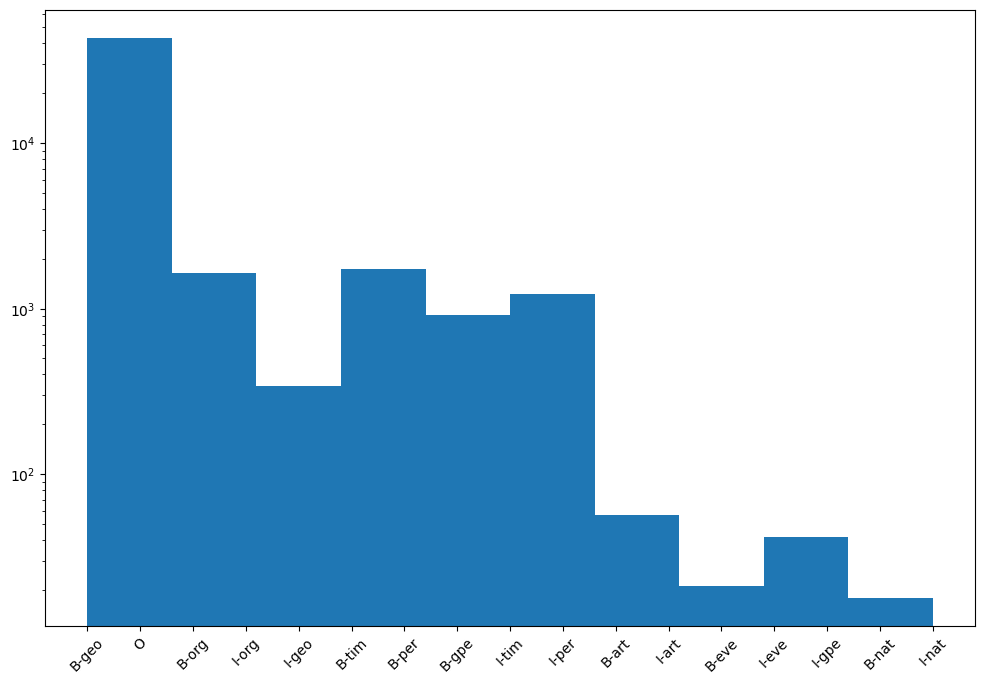

In [9]:
plt.figure(figsize=(12, 8))
plt.hist(df_train['Tag'], log=True)
plt.xticks(rotation=45)
plt.show()

# Transforming the data

In [10]:
df['Sentence'] = df.groupby("Sentence #")['Word'].transform(lambda x: " ".join(x))
df['Tags'] = df.groupby("Sentence #")['Tag'].transform(lambda x: " ".join(x))

In [11]:
new_df = df[['Sentence', 'Tags']]
new_df = new_df.drop_duplicates()
new_df.head()

,Sentence,Tags
Sentence #,,
1,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
5,The protest comes on the eve of the annual con...,O O O O O O O O O O O B-geo O O B-org I-org O ...
6,The party is divided over Britain 's participa...,O O O O O B-gpe O O O O B-geo O O O O O O O B-...
7,The London march came ahead of anti-war protes...,O B-geo O O O O O O O O O O O O B-geo O B-geo ...
8,The International Atomic Energy Agency is to h...,O B-org I-org I-org I-org O O O O O O O O B-ge...


In [12]:
sentences = new_df['Sentence'].to_list()
tags = new_df['Tags'].to_list()

In [13]:
# print some sentences and tags
def print_sen_tags(sentence, tags):
    words = sentence.split()
    tags_split = tags.split()
    
    for i in range(len(words)):
        print("(" + words[i] + " " + tags_split[i] + ")", end=" ")
    print()

In [14]:
for i in range(3):
    print_sen_tags(sentences[i], tags[i])

(Thousands O) (of O) (demonstrators O) (have O) (marched O) (through O) (London B-geo) (to O) (protest O) (the O) (war O) (in O) (Iraq B-geo) (and O) (demand O) (the O) (withdrawal O) (of O) (British B-gpe) (troops O) (from O) (that O) (country O) (. O) 
(The O) (protest O) (comes O) (on O) (the O) (eve O) (of O) (the O) (annual O) (conference O) (of O) (Britain B-geo) ('s O) (ruling O) (Labor B-org) (Party I-org) (in O) (the O) (southern O) (English B-gpe) (seaside O) (resort O) (of O) (Brighton B-geo) (. O) 
(The O) (party O) (is O) (divided O) (over O) (Britain B-gpe) ('s O) (participation O) (in O) (the O) (Iraq B-geo) (conflict O) (and O) (the O) (continued O) (deployment O) (of O) (8,500 O) (British B-gpe) (troops O) (in O) (that O) (country O) (. O) 


# Tokenizen the sentences and Tags

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
vocab_size = 3000
max_length = 30
num_classes = df['Tag'].nunique()
print(num_classes)

sen_tokenizer = Tokenizer(num_words=vocab_size,
                          lower=False,
                          filters="",
                         split=" ",
                         oov_token="<OOV>")
tag_tokenizer = Tokenizer(num_words=num_classes+1,
                          lower=False,
                          filters="",
                         split=" ",
                         oov_token="<OOV>")

17


In [17]:
sen_tokenizer.fit_on_texts(sentences)
sen_word_index = sen_tokenizer.word_index

tag_tokenizer.fit_on_texts(tags)
tag_word_index = tag_tokenizer.word_index

In [18]:
sequences = sen_tokenizer.texts_to_sequences(sentences)
tag_sequences = tag_tokenizer.texts_to_sequences(tags)

In [19]:
# printing tokenized sentence and tags
print(sequences[0])
print(tag_sequences[0])

print(len(sequences[0]))
print(len(tag_sequences[0]))

[651, 6, 554, 17, 971, 220, 503, 7, 371, 2, 162, 5, 55, 9, 771, 2, 865, 6, 163, 111, 21, 16, 50, 3]
[2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2]
24
24


In [20]:
new_sen_word_index = dict([(value, key) for key, value in sen_word_index.items()])
new_tag_word_index = dict([(value, key) for key, value in tag_word_index.items()])

# Add Padding to the sequences

In [21]:
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
padded_tags = pad_sequences(tag_sequences, maxlen=max_length, padding='post')

In [22]:
print(padded_sequences[0])
print(padded_tags[0])

[651   6 554  17 971 220 503   7 371   2 162   5  55   9 771   2 865   6
 163 111  21  16  50   3   0   0   0   0   0   0]
[2 2 2 2 2 2 3 2 2 2 2 2 3 2 2 2 2 2 6 2 2 2 2 2 0 0 0 0 0 0]


In [23]:
padded_sequences.shape

(2760, 30)

# Train test split

In [48]:
training_samples = 0.70
validation_samples = 0.15
testing_samples = 0.15

In [49]:
indices = np.arange(len(padded_tags))

In [50]:
X_preprocessed = padded_sequences[indices]
Y_preprocessed = padded_tags[indices]

In [51]:
X_train = X_preprocessed[: int(0.7 * len(X_preprocessed))]
print("Number of training examples: {}".format(len(X_train)))


X_val = X_preprocessed[int(0.7 * len(X_preprocessed)): int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1)]
print("Number of validation examples: {}".format(len(X_val)))


X_test = X_preprocessed[int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1):]
print("Number of testing examples: {}".format(len(X_test)))


Y_train = Y_preprocessed[: int(0.7 * len(X_preprocessed))]
Y_val = Y_preprocessed[int(0.7 * len(X_preprocessed)): int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1)]
Y_test = Y_preprocessed[int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1):]

print("Total number of examples after shuffling and splitting: {}".format(len(X_train) + len(X_val) + len(X_test)))

Number of training examples: 1931
Number of validation examples: 415
Number of testing examples: 414
Total number of examples after shuffling and splitting: 2760


# Modelling

## Utility function for plotting training

In [63]:
def plot_model_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=80)

    ax[0].plot(epochs, acc, label = "Training Accuracy", color='darkblue')
    ax[0].plot(epochs, val_acc, label = "Validation Accuracy", color='darkgreen')
    ax[0].grid(alpha=0.3)
    ax[0].title.set_text('Training Vs Validation Accuracy')
    plt.setp(ax[0], xlabel='Epochs')
    plt.setp(ax[0], ylabel='Accuracy')

    ax[0].legend(loc=0)

    ax[1].plot(epochs, loss, label = "Training Loss", color='darkblue')
    ax[1].plot(epochs, val_loss, label = "Validation Loss", color='darkgreen')
    ax[1].grid(alpha=0.3)
    ax[1].title.set_text('Training Vs Validation Loss')
    plt.setp(ax[1], xlabel='Epochs')
    plt.setp(ax[1], ylabel='Loss')
    
    ax[1].legend(loc=0)

    plt.show()

def run_model(model, epochs=30):
    model.summary()
    model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val))
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    accuracies.append(accuracy)
    #print("Accuracy on test data is " + str(np.round(accuracy*100, 2)) + "%")
    plot_model_curves(history)

accuracies = []

## Single layer RNN

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 30, 32)            96000     
                                                                 
 simple_rnn_19 (SimpleRNN)   (None, 30, 8)             328       
                                                                 
 time_distributed_14 (TimeDi  (None, 30, 18)           162       
 stributed)                                                      
                                                                 
Total params: 96,490
Trainable params: 96,490
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
61/61 [==============================] - 6s 34ms/step - loss: 2.5536 - accuracy: 0.3969 - val_loss: 2.0299 - val_accuracy: 0.8377
Epoch 2/30
61/61 [==============================] - 1s 20ms/step - loss: 1.5225 - accuracy: 0.8483 - val_l

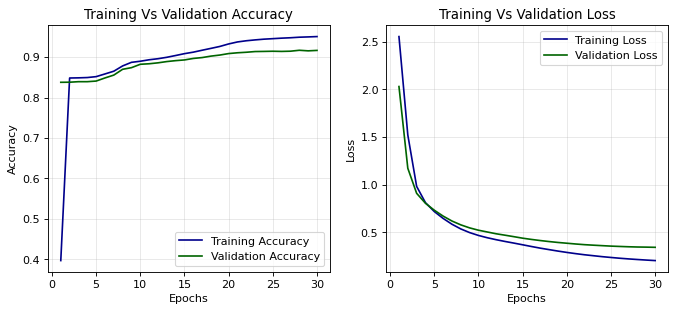

In [64]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 32, mask_zero=True, input_length=30),
    tf.keras.layers.SimpleRNN(8, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_classes+1, activation='softmax'))
])

run_model(model1)

## Multi layer RNN

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 30, 16)            48000     
                                                                 
 simple_rnn_20 (SimpleRNN)   (None, 30, 8)             200       
                                                                 
 simple_rnn_21 (SimpleRNN)   (None, 30, 8)             136       
                                                                 
 time_distributed_15 (TimeDi  (None, 30, 18)           162       
 stributed)                                                      
                                                                 
Total params: 48,498
Trainable params: 48,498
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
61/61 [==============================] - 9s 52ms/step - loss: 2.4032 - accuracy: 0.5047 - val_loss: 1.81

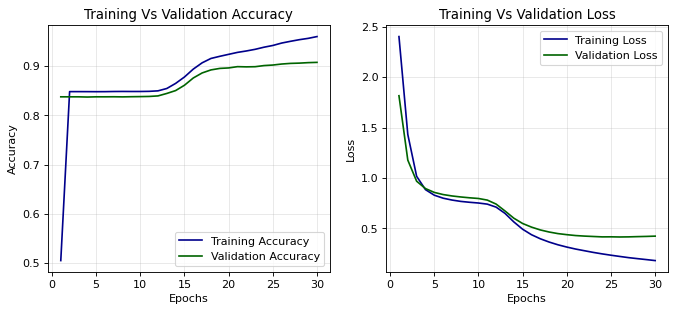

In [65]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16, mask_zero=True, input_length=30),
    tf.keras.layers.SimpleRNN(8, return_sequences=True),
    tf.keras.layers.SimpleRNN(8, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_classes+1, activation='softmax'))
])

run_model(model2)

In [62]:
accuracies

[0.9208523631095886, 0.9011741876602173]

# Predictions

In [32]:
test_pred = model1.predict(X_test, verbose=0)

In [33]:
test_pred = test_pred.argmax(axis=-1)

In [36]:
def predict_sentences(idx):
    sentence = ""
    for index in X_test[idx]:
        if index==0:
            sentence += "P"
        else:
            sentence += new_sen_word_index[index]
        sentence += " "

    tag = ""
    for index in Y_test[idx]:
        if index==0:
            tag += "P"
        else:
            tag += new_tag_word_index[index]
        tag += " "

    predicted_tag = ""
    for index in test_pred[idx]:
        if index==0:
            predicted_tag += "P"
        else:
            predicted_tag += new_tag_word_index[index]
        predicted_tag += " "
    print("Test sentence:", end=" ")
    print(sentence)
    print("Original tags:", end=" ")
    print(tag)
    print("Predicted tags:", end=" ")
    print(predicted_tag)

In [37]:
for i in range(4,8):
    predict_sentences(i)
    print("")
    print(i)

Test sentence: <OOV> Iranian news reports say parliament has rejected President Mahmoud Ahmadinejad 's third nominee for the post of oil minister . P P P P P P P P P 
Original tags: O B-gpe O O O O O O B-per I-per I-per O O O O O O O O O O P P P P P P P P P 
Predicted tags: O B-gpe O O O O O O B-per I-per I-per O O O O O O O O O O O O O O O O O O O 

4
Test sentence: The president 's first nominee for the post , Ali <OOV> was rejected in August by lawmakers who said he was not <OOV> . P P P P P P 
Original tags: O O O O O O O O O B-per I-per O O O B-tim O O O O O O O O O P P P P P P 
Predicted tags: O O O O O O O O O B-per I-per O O O B-tim O O O O O O O O O O O O O O O 

5
Test sentence: The ministry is currently being run by a deputy oil minister under former President Mohammed Khatami . P P P P P P P P P P P P P 
Original tags: O O O O O O O O O O O O O B-per I-per I-per O P P P P P P P P P P P P P 
Predicted tags: O O O O O O O O O O O O O B-per B-per I-per O O O O O O O O O O O O 